In [58]:
import os
import sys
current_dir = os.getcwd()
grand_package_root = os.path.join(current_dir,'..')
sys.path.insert(0, grand_package_root)
print(f"Répertoire racine du package ajouté à sys.path : {grand_package_root}")

Répertoire racine du package ajouté à sys.path : /home/jovyan/persistent/EA_Project/Analysis/..


In [59]:
import numpy as np
import numpy.random as rnd
import itertools
import matplotlib.pyplot as plt
from scipy.ndimage import convolve, generate_binary_structure
from IPython import display
import pandas as pd
import time
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import seaborn as sns # Needed for boxplot
import os # For directory management
from IPython.display import display

# Imports
from Design.Ising import Configuration
from Production.Exact_Energy import exact_1d_ising_energy, compute_relative_error
from Production.RBM_GD import RBM
from Production.RBM_SR import RBMSR


In [60]:
plt.rcParams.update({'font.size': 14}) 

plt.rcParams['axes.titlesize'] = 18    
plt.rcParams['axes.labelsize'] = 16    
plt.rcParams['xtick.labelsize'] = 12   
plt.rcParams['ytick.labelsize'] = 12   
plt.rcParams['figure.titlesize'] = 20  

# We first observe a first example using the gradient descent

In [61]:
n_hidden = 20 #M

#RBM with gradient descent:
N = 10 # Length of the Ising chain
rbm1 = RBM(n_visible=L, n_hidden=n_hidden, seed=42)

if __name__ == "__main__":
    J = 1.0
    H= 0.8

    E0, psi0 =exact_1d_ising_energy(L, J, H, periodic=True)
    print(E0, type(E0))

    print("Ground state energy =", E0)
    print("Vector shape =", psi0.shape)
    print("Norm =", np.linalg.norm(psi0))

-9.365204456437201 <class 'numpy.float64'>
Ground state energy = -9.365204456437201
Vector shape = (256,)
Norm = 1.0


### This is a first observation of the convergence of the energy: 

=== Training starts ===


/home/jovyan/persistent/EA_Project/Analysis/../Production/RBM_GD.py:260: ComplexWarning: Casting complex values to real discards the imaginary part
  E_local = float(self.local_energy(temp_config))  # ensure scalar


Epoch   0: E_NQS =  -8.1304, E_exact = -11.6909, ε_rel = 0.304555,  Accept = 0.978
Epoch  10: E_NQS =  -7.8206, E_exact = -11.6909, ε_rel = 0.331052,  Accept = 0.962
Epoch  20: E_NQS =  -7.9822, E_exact = -11.6909, ε_rel = 0.317235,  Accept = 0.917
Epoch  30: E_NQS =  -8.0169, E_exact = -11.6909, ε_rel = 0.314262,  Accept = 0.898
Epoch  40: E_NQS =  -8.6635, E_exact = -11.6909, ε_rel = 0.258955,  Accept = 0.846
Epoch  50: E_NQS =  -8.1386, E_exact = -11.6909, ε_rel = 0.303854,  Accept = 0.853
Epoch  60: E_NQS =  -8.8006, E_exact = -11.6909, ε_rel = 0.247228,  Accept = 0.723
Epoch  70: E_NQS =  -9.2372, E_exact = -11.6909, ε_rel = 0.209880,  Accept = 0.546
Epoch  80: E_NQS =  -9.7526, E_exact = -11.6909, ε_rel = 0.165797,  Accept = 0.510
Epoch  90: E_NQS = -10.0092, E_exact = -11.6909, ε_rel = 0.143853,  Accept = 0.464
Epoch 100: E_NQS = -10.4604, E_exact = -11.6909, ε_rel = 0.105257,  Accept = 0.275
Epoch 110: E_NQS = -11.9609, E_exact = -11.6909, ε_rel = -0.023090,  Accept = 0.058
Epo

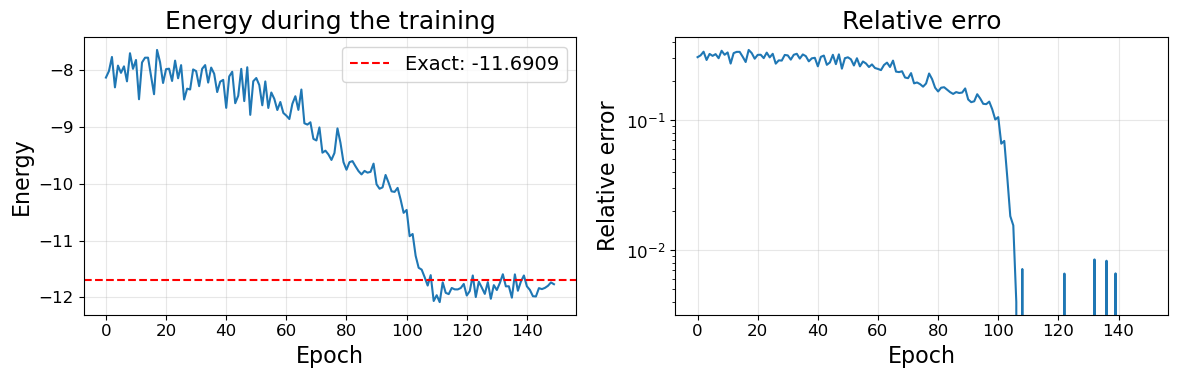

In [16]:
import time
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # Needed for boxplot
from IPython.display import display

# Removed SAVE_DIR
SEED_MAX = 2**32

def generate_title_info(df):
    """
    Analyzes the DataFrame to generate a standardized title prefix 
    summarizing all fixed and varied parameters, using LaTeX notation.
    """
    # Analyze parameters and format for LaTeX title
    info = []
    
    # Analyze System Size N
    N_vals = df['N'].unique()
    # CORRECTION HERE: Changed "$L=" to "$N=" inside the f-string
    N_str = f"$N={N_vals[0]}$" if len(N_vals) == 1 else f"$N \in [{min(N_vals)}, {max(N_vals)}]$"
    info.append(N_str)
    
    # Analyze Hidden Units (M)
    M_vals = df['n_hidden'].unique()
    M_str = f"$M={M_vals[0]}$" if len(M_vals) == 1 else f"$M \in$ \{{ {', '.join(map(str, sorted(M_vals)))} \}}"
    info.append(M_str)

    # Analyze Physical Parameters (J, H)
    J_vals = df['J'].unique()
    H_vals = df['H'].unique()
    J_str = f"$J={J_vals[0]:.1f}" if len(J_vals) == 1 else f"$J \in [{min(J_vals):.1f}, {max(J_vals):.1f}]"
    H_str = f"H={H_vals[0]:.1f}$" if len(H_vals) == 1 else f"H \in [{min(H_vals):.1f}, {max(H_vals):.1f}]$"
    info.append(f"{J_str}, {H_str}")
    
    # Analyze Learning Rate (LR)
    LR_vals = df['lr'].unique()
    LR_str = f"$LR={LR_vals[0]:.2f}$" if len(LR_vals) == 1 else f"$LR \in$ \{{ {', '.join(f'{v:.2f}' for v in sorted(LR_vals))} \}}"
    info.append(LR_str)

    # Analyze Sample Size (N_samples)
    N_samples_vals = df['n_samples_per_epoch'].unique()
    N_samples_str = f"$N_{{samples}}={N_samples_vals[0]}$" if len(N_samples_vals) == 1 else f"$N_{{samples}} \in$ \{{ {', '.join(map(str, sorted(N_samples_vals)))} \}}"
    info.append(N_samples_str)

    # Analyze Epochs (N_epochs)
    N_epochs_vals = df['n_epochs'].unique()
    N_epochs_str = f"$N_{{epochs}}={N_epochs_vals[0]}$" if len(N_epochs_vals) == 1 else f"$N_{{epochs}} \in$ \{{ {', '.join(map(str, sorted(N_epochs_vals)))} \}}"
    info.append(N_epochs_str)

    # Combine all info separated by '|'
    return " | ".join(info)


def run_single_setting(N, n_hidden, seed, n_epochs, n_samples_per_epoch, lr, J, H, verbose=False):
    """Instancie un RBM, entraîne rapidement et renvoie métriques sommaires."""
    #Instantiate RBM, run fast VMC training, and return summary metrics.
    rng_seed = seed
    rbm = RBM(n_visible=N, n_hidden=n_hidden, seed=rng_seed)
    start = time.time()
    energies, rel_errors = rbm.train(
        n_epochs=n_epochs,
        n_samples_per_epoch=n_samples_per_epoch,
        learning_rate=lr,
        J=J,
        H=H,
        verbose=False 
    )
    
    duration = time.time() - start
    E_final = energies[-1]
    eps_final = rel_errors[-1]
    
    E_exact = exact_1d_ising_energy(N, J, H, periodic=True)[0]
    
    # Compute average magnetization over a sample set.
    samples, es, acc = rbm.sample(n_samples=200, n_burnin=200, J=J, H=H)
    mags = np.mean(np.abs(np.sum(samples, axis=1))) / N  # mag abs moyenne
    # optionally compute variance of energies from sample set
    energy_var = np.var(es) if len(es)>0 else np.nan
    return {
        "N": N, "n_hidden": n_hidden, "alpha": n_hidden / N,
        "seed": seed, "n_epochs": n_epochs, "n_samples_per_epoch": n_samples_per_epoch,
        "lr": lr, "J": J, "H": H,
        "E_nqs": float(E_final), "eps_rel": float(eps_final),
        "E_exact": float(E_exact),
        "accept_rate_est": float(acc),
        "mag_abs": float(mags),
        "energy_var": float(energy_var),
        "duration_s": float(duration)
    }

def grid_search_and_collect(param_grid, repeats=3, progress=True):
    """
    param_grid: dict of lists, e.g.
      {"N":[8], "n_hidden":[8,16,32], "n_epochs":[50], "n_samples_per_epoch":[200],
       "lr":[0.01,0.05], "J":[1.0], "H":[0.0,0.5]}
    returns pandas.DataFrame
    """
    keys = list(param_grid.keys())
    combos = list(itertools.product(*(param_grid[k] for k in keys)))
    results = []
    total = len(combos) * repeats
    i = 0
    for combo in combos:
        params = dict(zip(keys, combo))
        for r in range(repeats):
            
            seed = params.get("seed", None)
            
            if seed is None:
                # If seed is not provided, use entropy but constrain to NumPy's limit
                seed_run = np.random.SeedSequence().entropy % SEED_MAX
            else:
                # If seed is provided, use seed + repeat number, also constrained
                seed_run = (seed + r) % SEED_MAX
            
            # Ensure the seed is an integer
            seed_run = int(seed_run)
            
            # map required arguments
            #Map parameters to the single run function.
            res = run_single_setting(
                N = params.get("N", 8),
                n_hidden = params.get("n_hidden", max(1, int(params.get("alpha",1)*params.get("N",8)))),
                seed = seed_run, # Use the corrected seed
                n_epochs = params.get("n_epochs", 50),
                n_samples_per_epoch = params.get("n_samples_per_epoch", 200),
                lr = params.get("lr", 0.01),
                J = params.get("J", 1.0),
                H = params.get("H", 0.0),
            )
            results.append(res)
            i += 1
            if progress:
                print(f"Run {i}/{total}: N={res['N']} n_hidden={res['n_hidden']} lr={res['lr']} J={res['J']} H={res['H']} -> eps_rel={res['eps_rel']:.3e}")
    
    df = pd.DataFrame(results)
    return df

#Visualisation
def boxplot_metric(df, param, metric="eps_rel"):
    """Boxplot of metric vs param (param is column name), shows the figure."""
    #Displays the figure.
    plt.figure(figsize=(8,4))
    sns.boxplot(x=param, y=metric, data=df)
    
    title_prefix = generate_title_info(df)
    plt.title(f"Final Relative Error vs. {param}\n({title_prefix})", fontsize=9)
    
    plt.grid(alpha=0.2)
    plt.tight_layout()
    
    # Show Figure
    plt.show()

def heatmap_2params(df, p1, p2, agg="mean", metric="eps_rel"):
    """Heatmap of metric aggregated across runs for two parameters, shows the figure."""
    #Displays the figure.
    
    df_pivot = df.copy()
    # Convert float parameters to string for clean indexing
    if df_pivot[p1].dtype == 'float64':
        df_pivot[p1] = df_pivot[p1].round(4).astype(str)
    if df_pivot[p2].dtype == 'float64':
        df_pivot[p2] = df_pivot[p2].round(4).astype(str)
        
    table = df_pivot.groupby([p1,p2])[metric].agg(agg).unstack()
    
    plt.figure(figsize=(6,5))
    im = plt.imshow(table.values, aspect='auto', origin='lower', cmap='viridis_r')
    plt.colorbar(im, label=f"{metric} ({agg})")
    
    plt.xticks(range(table.shape[1]), table.columns, rotation=45)
    plt.yticks(range(table.shape[0]), table.index)
    plt.xlabel(p2); plt.ylabel(p1)

    title_prefix = generate_title_info(df)
    plt.title(f"{metric} ({agg}) vs {p1} and {p2}\n({title_prefix})", fontsize=9)
    
    plt.tight_layout()

    # Show Figure
    plt.show()

def summary_table(df):
    """Affiche des stats sommaires groupées par paramètres d'intérêt."""
    #Displays summary statistics grouped by key parameters.
    res = (
        df.groupby(["N", "n_hidden", "lr", "J", "H"])
        .agg({
            "E_nqs": ["mean", "std"],
            "eps_rel": ["mean", "std"],
            "accept_rate_est": ["mean", "std"],
            "mag_abs": ["mean", "std"]
        })
        .reset_index()
    )

    display(res)


param_grid = {
    "N":[8],
    "n_hidden":[5, 10, 15],
    "n_epochs":[100],
    "n_samples_per_epoch":[500],
    "lr":[ 0.01, 0.05],
    "J":[1.0],
    "H":[1.0]
}


df_results = grid_search_and_collect(param_grid, repeats=3)

boxplot_metric(df_results, "n_hidden", metric="eps_rel")
heatmap_2params(df_results, "n_hidden", "lr", metric="eps_rel")
summary_table(df_results)

### Then we try to see in general the influence of parameters (To have a first Idea)

Run 1/18: N=8 n_hidden=5 lr=0.01 J=1.0 H=1.0 -> eps_rel=4.344e-02
Run 2/18: N=8 n_hidden=5 lr=0.01 J=1.0 H=1.0 -> eps_rel=7.732e-02
Run 3/18: N=8 n_hidden=5 lr=0.01 J=1.0 H=1.0 -> eps_rel=6.578e-02
Run 4/18: N=8 n_hidden=5 lr=0.05 J=1.0 H=1.0 -> eps_rel=8.252e-03
Run 5/18: N=8 n_hidden=5 lr=0.05 J=1.0 H=1.0 -> eps_rel=6.548e-03
Run 6/18: N=8 n_hidden=5 lr=0.05 J=1.0 H=1.0 -> eps_rel=2.514e-02
Run 7/18: N=8 n_hidden=10 lr=0.01 J=1.0 H=1.0 -> eps_rel=3.860e-03
Run 8/18: N=8 n_hidden=10 lr=0.01 J=1.0 H=1.0 -> eps_rel=-8.687e-04
Run 9/18: N=8 n_hidden=10 lr=0.01 J=1.0 H=1.0 -> eps_rel=8.339e-02
Run 10/18: N=8 n_hidden=10 lr=0.05 J=1.0 H=1.0 -> eps_rel=1.684e-02
Run 11/18: N=8 n_hidden=10 lr=0.05 J=1.0 H=1.0 -> eps_rel=1.266e-02
Run 12/18: N=8 n_hidden=10 lr=0.05 J=1.0 H=1.0 -> eps_rel=7.838e-03
Run 13/18: N=8 n_hidden=15 lr=0.01 J=1.0 H=1.0 -> eps_rel=2.505e-02
Run 14/18: N=8 n_hidden=15 lr=0.01 J=1.0 H=1.0 -> eps_rel=9.054e-03
Run 15/18: N=8 n_hidden=15 lr=0.01 J=1.0 H=1.0 -> eps_rel=-3.7

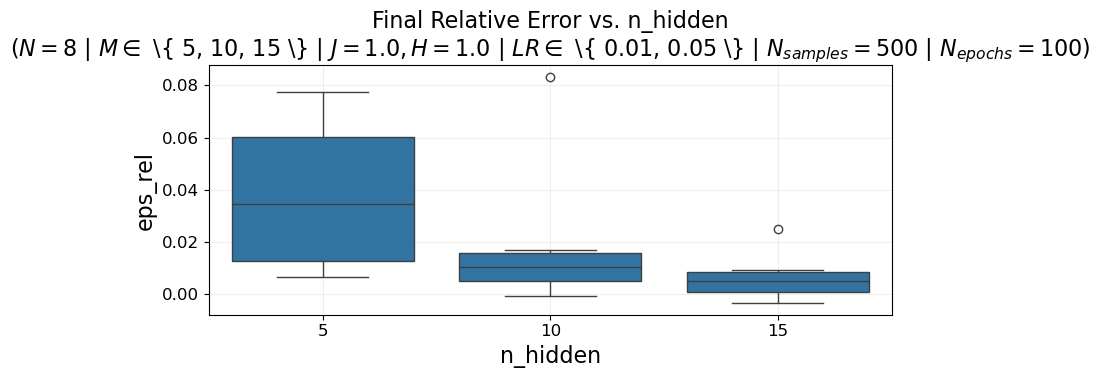

Figure saved to: Figures/heatmap_eps_rel_vs_n_hidden_lr.png


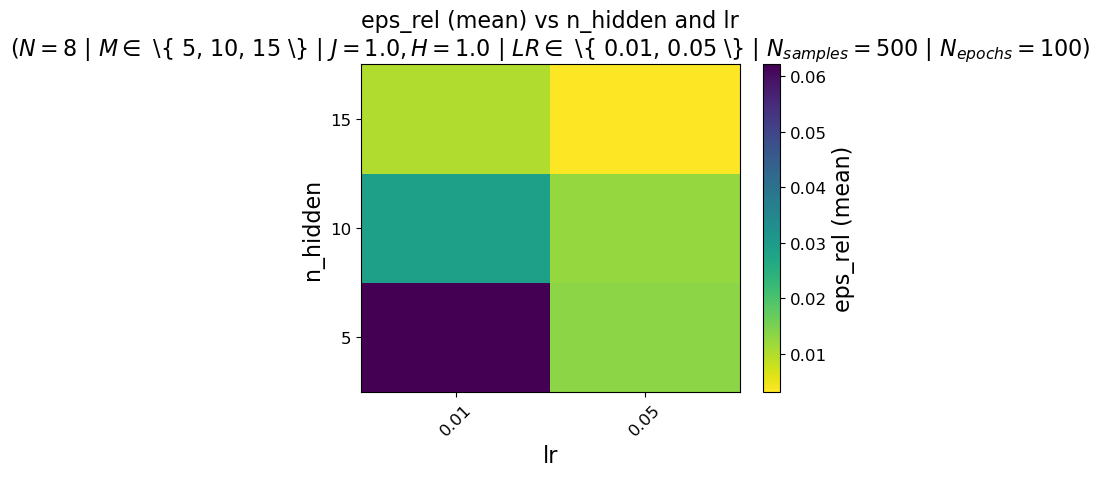

N n_hidden    lr    J    H      E_nqs             eps_rel            \
                                    mean       std      mean       std   
0  8        5  0.01  1.0  1.0  -9.614182  0.176570  0.062183  0.017224   
1  8        5  0.05  1.0  1.0 -10.115191  0.105337  0.013312  0.010275   
2  8       10  0.01  1.0  1.0  -9.956483  0.485312  0.028793  0.047340   
3  8       10  0.05  1.0  1.0 -10.124067  0.046191  0.012446  0.004506   
4  8       15  0.01  1.0  1.0 -10.147811  0.147749  0.010130  0.014412   
5  8       15  0.05  1.0  1.0 -10.219867  0.033046  0.003101  0.003223   

  accept_rate_est             mag_abs            
             mean       std      mean       std  
0        0.250695  0.052709  0.580833  0.074764  
1        0.229451  0.064966  0.586667  0.085306  
2        0.252319  0.143845  0.565833  0.043899  
3        0.279476  0.034034  0.491667  0.055132  
4        0.162154  0.030164  0.631667  0.046120  
5        0.274389  0.109649  0.522500  0.077621

In [63]:
# Output directory for saving figures
SAVE_DIR = "Figures" 
SEED_MAX = 2**32

def generate_title_info(df):
    """
    Analyzes the DataFrame to generate a standardized title prefix 
    summarizing all fixed and varied parameters, using LaTeX notation.
    """
    info = []
    
    # Analyze System Size N
    N_vals = df['N'].unique()
    # CORRECTION HERE: Changed "$L=" to "$N=" inside the f-string
    N_str = f"$N={N_vals[0]}$" if len(N_vals) == 1 else f"$N \in [{min(N_vals)}, {max(N_vals)}]$"
    info.append(N_str)
    
    # Analyze Hidden Units (M)
    M_vals = df['n_hidden'].unique()
    M_str = f"$M={M_vals[0]}$" if len(M_vals) == 1 else f"$M \in$ \{{ {', '.join(map(str, sorted(M_vals)))} \}}"
    info.append(M_str)

    # Analyze Physical Parameters (J, H)
    J_vals = df['J'].unique()
    H_vals = df['H'].unique()
    J_str = f"$J={J_vals[0]:.1f}" if len(J_vals) == 1 else f"$J \in [{min(J_vals):.1f}, {max(J_vals):.1f}]"
    H_str = f"H={H_vals[0]:.1f}$" if len(H_vals) == 1 else f"H \in [{min(H_vals):.1f}, {max(H_vals):.1f}]$"
    info.append(f"{J_str}, {H_str}")
    
    # Analyze Learning Rate (LR)
    LR_vals = df['lr'].unique()
    LR_str = f"$LR={LR_vals[0]:.2f}$" if len(LR_vals) == 1 else f"$LR \in$ \{{ {', '.join(f'{v:.2f}' for v in sorted(LR_vals))} \}}"
    info.append(LR_str)

    # Analyze Sample Size (N_samples)
    N_samples_vals = df['n_samples_per_epoch'].unique()
    N_samples_str = f"$N_{{samples}}={N_samples_vals[0]}$" if len(N_samples_vals) == 1 else f"$N_{{samples}} \in$ \{{ {', '.join(map(str, sorted(N_samples_vals)))} \}}"
    info.append(N_samples_str)

    # Analyze Epochs (N_epochs)
    N_epochs_vals = df['n_epochs'].unique()
    N_epochs_str = f"$N_{{epochs}}={N_epochs_vals[0]}$" if len(N_epochs_vals) == 1 else f"$N_{{epochs}} \in$ \{{ {', '.join(map(str, sorted(N_epochs_vals)))} \}}"
    info.append(N_epochs_str)

    # Combine all info separated by '|'
    return " | ".join(info)


def run_single_setting(N, n_hidden, seed, n_epochs, n_samples_per_epoch, lr, J, H, verbose=False):
    """Instancie un RBM, entraîne rapidement et renvoie métriques sommaires."""
    #Instantiate RBM, run fast VMC training, and return summary metrics.
    rng_seed = seed
    rbm = RBM(n_visible=N, n_hidden=n_hidden, seed=rng_seed)
    start = time.time()
    energies, rel_errors = rbm.train(
        n_epochs=n_epochs,
        n_samples_per_epoch=n_samples_per_epoch,
        learning_rate=lr,
        J=J,
        H=H,
        verbose=False 
    )
    
    duration = time.time() - start
    E_final = energies[-1]
    eps_final = rel_errors[-1]
    
    E_exact = exact_1d_ising_energy(N, J, H, periodic=True)[0]
    
    # Compute average magnetization over a sample set.
    samples, es, acc = rbm.sample(n_samples=200, n_burnin=200, J=J, H=H)
    mags = np.mean(np.abs(np.sum(samples, axis=1))) / N  # mag abs moyenne
    # optionally compute variance of energies from sample set
    energy_var = np.var(es) if len(es)>0 else np.nan
    return {
        "N": N, "n_hidden": n_hidden, "alpha": n_hidden / N,
        "seed": seed, "n_epochs": n_epochs, "n_samples_per_epoch": n_samples_per_epoch,
        "lr": lr, "J": J, "H": H,
        "E_nqs": float(E_final), "eps_rel": float(eps_final),
        "E_exact": float(E_exact),
        "accept_rate_est": float(acc),
        "mag_abs": float(mags),
        "energy_var": float(energy_var),
        "duration_s": float(duration)
    }

def grid_search_and_collect(param_grid, repeats=3, progress=True):
    """
    param_grid: dict of lists, e.g.
      {"N":[8], "n_hidden":[8,16,32], "n_epochs":[50], "n_samples_per_epoch":[200],
       "lr":[0.01,0.05], "J":[1.0], "H":[0.0,0.5]}
    returns pandas.DataFrame
    """
    keys = list(param_grid.keys())
    combos = list(itertools.product(*(param_grid[k] for k in keys)))
    results = []
    total = len(combos) * repeats
    i = 0
    for combo in combos:
        params = dict(zip(keys, combo))
        for r in range(repeats):
            
            seed = params.get("seed", None)
            
            if seed is None:
                # If seed is not provided, use entropy but constrain to NumPy's limit
                seed_run = np.random.SeedSequence().entropy % SEED_MAX
            else:
                # If seed is provided, use seed + repeat number, also constrained
                seed_run = (seed + r) % SEED_MAX
            
            # Ensure the seed is an integer
            seed_run = int(seed_run)
            
            # map required arguments
            #Map parameters to the single run function.
            res = run_single_setting(
                N = params.get("N", 8),
                n_hidden = params.get("n_hidden", max(1, int(params.get("alpha",1)*params.get("N",8)))),
                seed = seed_run, # Use the corrected seed
                n_epochs = params.get("n_epochs", 50),
                n_samples_per_epoch = params.get("n_samples_per_epoch", 200),
                lr = params.get("lr", 0.01),
                J = params.get("J", 1.0),
                H = params.get("H", 0.0),
            )
            results.append(res)
            i += 1
            if progress:
                print(f"Run {i}/{total}: N={res['N']} n_hidden={res['n_hidden']} lr={res['lr']} J={res['J']} H={res['H']} -> eps_rel={res['eps_rel']:.3e}")
    
    df = pd.DataFrame(results)
    return df

#Visualisation
def boxplot_metric(df, param, metric="eps_rel", save_dir=SAVE_DIR):
    """Boxplot of metric vs param (param is column name), saves and shows the figure."""
    #Saves the figure to the specified directory and then displays it.
    plt.figure(figsize=(8,4))
    sns.boxplot(x=param, y=metric, data=df)
    
    title_prefix = generate_title_info(df)
    # The title font size will now use the updated rcParams (16 or 18)
    plt.title(f"Final Relative Error vs. {param}\n({title_prefix})")
    
    plt.grid(alpha=0.2)
    plt.tight_layout()
    
    # Save Figure
    os.makedirs(save_dir, exist_ok=True)
    filename = f"boxplot_{metric}_vs_{param}.png"
    save_path = os.path.join(save_dir, filename)
    plt.savefig(save_path)
    print(f"Figure saved to: {save_path}")
    
    # Show Figure
    plt.show()

def heatmap_2params(df, p1, p2, agg="mean", metric="eps_rel", save_dir=SAVE_DIR):
    """Heatmap of metric aggregated across runs for two parameters, saves and shows the figure."""
    #Saves the figure to the specified directory and then displays it.
    
    df_pivot = df.copy()
    # Convert float parameters to string for clean indexing
    if df_pivot[p1].dtype == 'float64':
        df_pivot[p1] = df_pivot[p1].round(4).astype(str)
    if df_pivot[p2].dtype == 'float64':
        df_pivot[p2] = df_pivot[p2].round(4).astype(str)
        
    table = df_pivot.groupby([p1,p2])[metric].agg(agg).unstack()
    
    plt.figure(figsize=(6,5))
    im = plt.imshow(table.values, aspect='auto', origin='lower', cmap='viridis_r')
    plt.colorbar(im, label=f"{metric} ({agg})")
    
    plt.xticks(range(table.shape[1]), table.columns, rotation=45)
    plt.yticks(range(table.shape[0]), table.index)
    plt.xlabel(p2); plt.ylabel(p1)

    title_prefix = generate_title_info(df)
    # The title font size will now use the updated rcParams (16 or 18)
    plt.title(f"{metric} ({agg}) vs {p1} and {p2}\n({title_prefix})")
    
    plt.tight_layout()

    # Save Figure
    os.makedirs(save_dir, exist_ok=True)
    filename = f"heatmap_{metric}_vs_{p1}_{p2}.png"
    save_path = os.path.join(save_dir, filename)
    plt.savefig(save_path)
    print(f"Figure saved to: {save_path}")

    # Show Figure
    plt.show()

def summary_table(df):
    """Affiche des stats sommaires groupées par paramètres d'intérêt."""
    #Displays summary statistics grouped by key parameters.
    res = (
        df.groupby(["N", "n_hidden", "lr", "J", "H"])
        .agg({
            "E_nqs": ["mean", "std"],
            "eps_rel": ["mean", "std"],
            "accept_rate_est": ["mean", "std"],
            "mag_abs": ["mean", "std"]
        })
        .reset_index()
    )

    display(res)


param_grid = {
    "N":[8],
    "n_hidden":[5, 10, 15],
    "n_epochs":[100],
    "n_samples_per_epoch":[500],
    "lr":[ 0.01, 0.05],
    "J":[1.0],
    "H":[1.0]
}


df_results = grid_search_and_collect(param_grid, repeats=3)

boxplot_metric(df_results, "n_hidden", metric="eps_rel")
heatmap_2params(df_results, "n_hidden", "lr", metric="eps_rel")
summary_table(df_results)

### Then in order to compare our two ways of optimization: GD and SR, we fix the parameters at: 



=== Training RBM-SR ===


/home/jovyan/persistent/EA_Project/Analysis/../Production/RBM_SR.py:229: ComplexWarning: Casting complex values to real discards the imaginary part
  # Accumulate averages


Epoch   0: E_NQS = -20.4219, E_exact = -25.4910, ε_rel = 0.198860,  Accept = 0.975
Epoch  10: E_NQS = -22.8740, E_exact = -25.4910, ε_rel = 0.102665,  Accept = 0.663
Epoch  20: E_NQS = -23.9688, E_exact = -25.4910, ε_rel = 0.059716,  Accept = 0.570
Epoch  30: E_NQS = -24.4740, E_exact = -25.4910, ε_rel = 0.039897,  Accept = 0.519
Epoch  40: E_NQS = -24.5767, E_exact = -25.4910, ε_rel = 0.035867,  Accept = 0.466
Epoch  50: E_NQS = -25.0427, E_exact = -25.4910, ε_rel = 0.017586,  Accept = 0.457
Epoch  60: E_NQS = -25.2834, E_exact = -25.4910, ε_rel = 0.008143,  Accept = 0.389
Epoch  70: E_NQS = -24.8577, E_exact = -25.4910, ε_rel = 0.024844,  Accept = 0.424
Epoch  80: E_NQS = -25.1442, E_exact = -25.4910, ε_rel = 0.013603,  Accept = 0.383
Epoch  90: E_NQS = -25.1326, E_exact = -25.4910, ε_rel = 0.014061,  Accept = 0.354
Epoch  99: E_NQS = -25.0308, E_exact = -25.4910, ε_rel = 0.018055,  Accept = 0.352
=== Training RBM (Gradient Descent) ===


/home/jovyan/persistent/EA_Project/Analysis/../Production/RBM_GD.py:260: ComplexWarning: Casting complex values to real discards the imaginary part
  E_local = float(self.local_energy(temp_config))  # ensure scalar


Epoch   0: E_NQS = -20.4219, E_exact = -25.4910, ε_rel = 0.198860,  Accept = 0.975
Epoch  10: E_NQS = -19.4057, E_exact = -25.4910, ε_rel = 0.238724,  Accept = 0.952
Epoch  20: E_NQS = -20.6475, E_exact = -25.4910, ε_rel = 0.190008,  Accept = 0.954
Epoch  30: E_NQS = -20.1145, E_exact = -25.4910, ε_rel = 0.210916,  Accept = 0.919
Epoch  40: E_NQS = -20.2826, E_exact = -25.4910, ε_rel = 0.204324,  Accept = 0.883
Epoch  50: E_NQS = -20.2746, E_exact = -25.4910, ε_rel = 0.204636,  Accept = 0.864
Epoch  60: E_NQS = -20.7733, E_exact = -25.4910, ε_rel = 0.185073,  Accept = 0.724
Epoch  70: E_NQS = -22.8452, E_exact = -25.4910, ε_rel = 0.103792,  Accept = 0.452
Epoch  80: E_NQS = -23.4227, E_exact = -25.4910, ε_rel = 0.081139,  Accept = 0.292
Epoch  90: E_NQS = -23.5005, E_exact = -25.4910, ε_rel = 0.078086,  Accept = 0.308
Epoch  99: E_NQS = -23.9049, E_exact = -25.4910, ε_rel = 0.062221,  Accept = 0.263


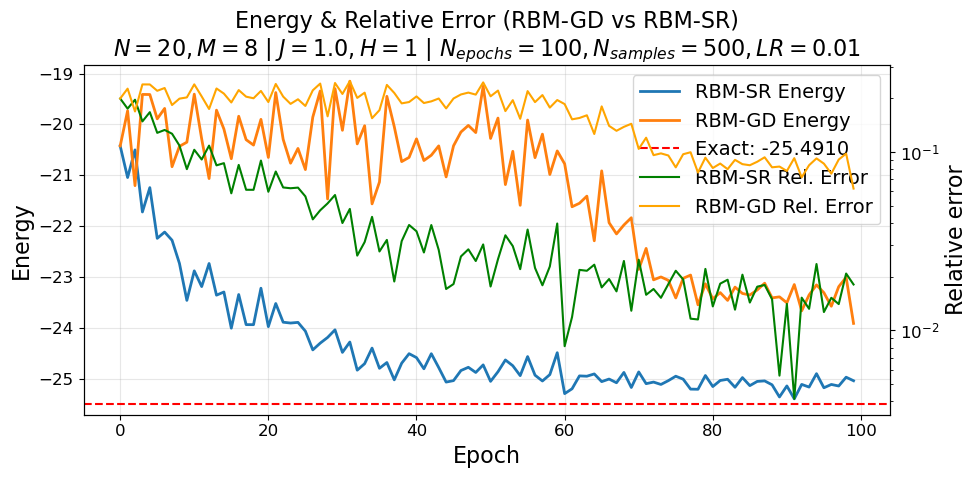

In [64]:
import numpy as np
import matplotlib.pyplot as plt

# Define these variables to ensure consistency between training and the plot title
n_epochs = 100
n_samples = 500
lr = 0.01
J_val = 1.0
H_val = 1
N=20

# Definition of both models
rbm_sr = RBMSR(n_visible=N, n_hidden=n_hidden, seed=42)
rbm_gd = RBM(n_visible=N, n_hidden=n_hidden, seed=42)

print("=== Training RBM-SR ===")
energies_sr, rel_errors_sr = rbm_sr.train(
    n_epochs=n_epochs,
    n_samples_per_epoch=n_samples,
    learning_rate=lr,
    J=J_val,
    H=H_val,
    verbose=True
)

print("=== Training RBM (Gradient Descent) ===")
energies_gd, rel_errors_gd = rbm_gd.train(
    n_epochs=n_epochs,
    n_samples_per_epoch=n_samples,
    learning_rate=lr,
    J=J_val,
    H=H_val,
    verbose=True
)

# Visualization on a single graph 
fig, ax1 = plt.subplots(figsize=(10, 5))

epochs_arr = np.arange(len(energies_sr))

# Energy Curves 
ax1.plot(energies_sr, label='RBM-SR Energy', linewidth=2)
ax1.plot(energies_gd, label='RBM-GD Energy', linewidth=2)

# Calculate exact energy for reference
E_exact = exact_1d_ising_energy(N, J_val, H_val, periodic=True)[0]
ax1.axhline(y=E_exact, color='r', linestyle='--', label=f'Exact: {E_exact:.4f}')

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Energy')
ax1.grid(True, alpha=0.3)

# Dynamic Title with Details 
# Using LaTeX formatting for mathematical symbols
title_str = (
    f"Energy & Relative Error (RBM-GD vs RBM-SR)\n"
    f"$N={N}, M={n_hidden}$ | $J={J_val}, H={H_val}$ | "
    f"$N_{{epochs}}={n_epochs}, N_{{samples}}={n_samples}, LR={lr}$"
)
ax1.set_title(title_str)

# Second axis for error 
ax2 = ax1.twinx()
# Log scale for relative error is usually better for visualization
ax2.semilogy(rel_errors_sr, label='RBM-SR Rel. Error', color='green')
ax2.semilogy(rel_errors_gd, label='RBM-GD Rel. Error', color='orange')
ax2.set_ylabel('Relative error')

# Combined Legend 
# Retrieve handles and labels from both axes to create a single legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.tight_layout()
plt.show()